# Flipping coins with Professor Mittens

In this lab we will look at the binomial distribution, central limit theorem, and analyse two data sets collected by [Professor Mittens](https://en.wikipedia.org/wiki/Mittens_(cat)) helping him interrogate the bais in the results of coin flips. Some of the questions are open-ended by design. Partial solutions will be distributed at the end of the session. The imports below are used in the provided solutions, consider these suggestions, not constraints. The answers use `altair` but you can use any plotting library you are comfortable with.

In [1]:
import pandas as pd
from scipy import stats
import altair as alt
from typing import List, Any, Tuple
from functools import reduce
from itertools import repeat
import math as math

## Parameter estimation of the binomial distribution

Bernoulli and binomial random variables are the typical way to represent the outcome of coin flips. Below we consider estimates of the probability of heads based on a known number of successes in a given number of trials and also a confidence interval (CI) for this based on the Wald method will be given.

Let $X$ be a binomial random variable (RV) which results from the number of heads when a coin is flipped $n$ times and the probability of coming up heads is $p$. For the time being we will assume that $n$ is know. The expected value of $X$ is $np$. So a simple way to estimate $p$ is to divide the number of heads, $X$, by the number of flips, $n$. This gives the estimate 

$$
\hat{p} = X / n.
$$

It turns out that this is a very sensible thing to do. The resulting estimate is called the maximum likelihood estimate (MLE) of $p$. It is also the result that one obtains via [the method of moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)).

Given an estimator though, we want to know how confident we are in the estimate it produces. Here we will use the Wald method to get the $95\%$ CI. It is a very simple method but is acceptable when we have a fair bit of data. The estimated standard error of $\hat{p}$ is $\sqrt{\hat{p}(1-\hat{p})/n}$, so the Wald CI is given by

$$
\hat{p} \pm z \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$

where $z$ is the appropriate quantile of the standard normal distribution. In the case of a $95\%$ distribution this is just $1.96$.

This is stated on the [wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution#Estimation_of_parameters) but there is also a reasonably clear description in [All of Statistics](https://link.springer.com/book/10.1007/978-0-387-21736-9) which you can get via SOLO.

### Exercise 1 part I

Professor Mittens is not very familiar with the binomial distribution and wants you to justify the estimator used above. Convince yourself that the estimate given above, $X/n$, is a sensible choice. Prove that it is either the MLE or the method of moments estimator for $p$. State the limitations on the estimator we are using for the CI.

### Partial answer

- Observe that the expected number of heads is $pn$ and solve for $p$.
- Consider each flip as a Bernoulli trial and optimise the resulting log-likelihood function
- The Wald estimate assumes you have enough data to justify an asymptotic solution so is unlikely to be accurate for small datasets.

### Exercise 1 part II

Implement a function called `wald_estimate_and_ci` which takes two arguments: `num_trials` which is $n$ in the description above, and `num_success` which is $X$ above. The function should return `(p_hat,(wald_lower,wald_upper))` where `p_hat` is $\hat{p}$ and `wald_x` are the limits on the $95\%$ CI using the Wald method.

In [2]:
CI = Tuple[float,float]
EstimateAndCI = Tuple[float,CI]

# the -> is to help you know that it is an EstimateAndCI later

def wald_estimate_and_ci(num_trials: int, num_success: int) -> EstimateAndCI:
    p_hat = num_success / num_trials
    z = 1.96
    delta = z * math.sqrt(p_hat * (1 - p_hat) / num_trials)
    return (p_hat,(p_hat - delta, p_hat + delta))

print(wald_estimate_and_ci(10,5))

(0.5, (0.19009678930349883, 0.8099032106965012))


### Exercise 2 part I

Look up how to simulate a random variable from a binomial distribution (it tells you [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom) if you want to use `scipy`). Then simulate a binomial random variable with $n=100$ and $p=0.6$. Then use the value and the `wald_estimate_and_ci` function to see how well you can estimate $p$. Write a couple of sentences to explain this.

### Exercise 2 part II

Repeat the process about 100000 times and see what proportion of the CIs capture the true value of $p$. Is it what you expect? Write a couple of sentences to explain what you found.

In [3]:
rand_xs = stats.binom.rvs(n = 100, p = 0.6, size = 100000)

def ci_contains_value(ci: CI, p: float) -> bool:
    lower,upper = ci
    return lower < p and p < upper

p_in_ci_bools = [ci_contains_value(wald_estimate_and_ci(100, x)[1], 0.6) for x in rand_xs]

reduce(lambda a, b: a + 1 if b else a, p_in_ci_bools, 0) / 100000

0.94849

### Exercise 2 part III

Are credible intervals and confidence intervals the same thing?

### Partial answer

No confidence intervals are talk about repeated experiments in frequentist statistics while credible intervals talk about posterior probability in Bayesian statistics.

## Central limit theorem

The central limit theorem tells us about the limiting distribution of the sample mean for distribution for an IID sample with a finite variance. It underpins many results in statistics and is important for reasoning about stochastic processes.

### Exercise 3 part I

Professor Mittens *really* likes to sound fancy and use the name of important theorems. Write down a statement of the law of large numbers. Write down a statement of the central limit theorem. Make sure you understand what each of them tells you.

**XWANS**

Law of large numbers: As your sample gets really large, your average gets really accurate and converges to the true mean

CLT: tells us about the rate of these conversions. It quantifies how much the sample average is going to fluctuate from the true value. 

### Partial answer

- $\hat{X}$ converges to $\mu$.
- $\sqrt{n}(\hat{X} - \mu) / \sigma$ converges in distribution to the standard normal distribution as the sample size increases.
- The LLN tells you what the limiting value is, the CLT tells you about how about the fluctuations.

### Exercise 3 part II

To see that the distribution of the sample mean converges to a normal distribution we will do a simulation study and compare the results with a Q-Q plot to see if it looks normally distributed. This will also demonstrate how to construct a Q-Q plot from first principles, not that you really want to do that. Carry out the following steps:

1. Write down the distribution of the sample mean given an IID sample of exponential random variables
2. Generate 100 sample means each based on a sample of 100 exponential random variables
3. Make a histogram and a Q-Q plot to see if the sample means do appear to follow a normal distribution

In [4]:
sample_size = 1000
num_replicates = 1000

sample_means = [stats.expon.rvs(scale = 5, size = sample_size).mean() for _ in range(num_replicates)]

plot_df = pd.DataFrame({"sample_mean": sample_means})

mesh_size = 100
x_vals = [0.02 * ix + 4 for ix in range(0,mesh_size)]

clt_scale = 5 / math.sqrt(sample_size)

clt_pdf = [mesh_size * stats.norm.pdf(x, loc = 5, scale = clt_scale) for x in x_vals]
clt_df = pd.DataFrame({"x": x_vals, "pdf": clt_pdf})

In [5]:
data_hist = (alt
                .Chart(plot_df)
                .mark_bar()
                .encode(x = alt.X("sample_mean:Q",
                                  bin = alt.BinParams(step = 0.1)),
                        y = alt.Y("count()")))

clt_line = (alt
               .Chart(clt_df)
               .mark_line(color = "red")
               .encode(x = "x",
                       y = "pdf"))

data_hist + clt_line

alt.LayerChart(...)

In [6]:
unit_mesh = [1 - (1 / len(sample_means)) * ix - (0.5 / len(sample_means)) for ix in range(0,len(sample_means))]
quantile_vals = [stats.norm.isf(u, loc = 5, scale = clt_scale) for u in unit_mesh]
sample_means.sort()
quant_df = pd.DataFrame({
    "sample_means": sample_means,
    "quantiles": quantile_vals})

ab_lims = [min(sample_means)-0.1, max(sample_means)+0.1]
abline_df = pd.DataFrame({"x": ab_lims, "y": ab_lims})

quant_points = (alt
                   .Chart(quant_df)
                   .mark_point()
                   .encode(x =  alt.X('sample_means:Q',
                                      scale=alt.Scale(zero=False),
                                      title = "Sample mean quantile"),
                           y = alt.Y('quantiles:Q',
                                      scale=alt.Scale(zero=False),
                                      title = "Normal quantile")))

ab_line = (alt
          .Chart(abline_df)
          .mark_line(color = "red")
          .encode(x = "x", y = "y"))

quant_points + ab_line

alt.LayerChart(...)

**XW NOTES**

We are building sampling distribution and the SD of the sampling distribution is the sample error

SD of sampling distribution is narrower that the population distribution because we are creating samples and so they will be concentrated around the mean

Exponential distribution has a single parameter, the rate parameter, the rate (which here is 1/5)
Scale here is what the python library uses for rate

Normality test just tells you the probability is is normal or not
Quantile-quantile plot tells you why it is not 

Understand what CIs are and how they relate to CLT

Red line shows the binomial distribution of the # of heads


#is it correct to calculate p for each student (coin) and then the take the mean value of all the ps? I get 0.401 as well

## Experimental results: flipping coins in series

Professor Mittens asked 15 of his students to each take turns flipping a coin 30 times and recording how many heads they got. He has a sneaking suspicion that some of the students did not actually do this properly, that they just wrote down some garbage and went to lunch early. We will help Mittens work out whether the coin that was used was fair, i.e. has an equal chance of showing heads or tails.

### Exercise 3 part I

Read the data in `experiement1.csv` into a `DataFrame`.

In [7]:
exp1 = pd.read_csv("experiment1.csv")

### Exercise 3 part II

Compute the point estimate and CI using the function you wrote above. Write a sentence explaining whether you think the coin is a _fair_ coin.

In [8]:
head_counts = exp1.drop(columns="flip_number").groupby("name").sum()
head_counts["name"] = head_counts.index.copy()

total_heads = int(head_counts["outcome"].sum())
num_people = int(head_counts["name"].unique().size)
num_flips = int(exp1["name"].value_counts().unique())

est_and_ci = wald_estimate_and_ci(num_success=total_heads, 
                                  num_trials=num_people * num_flips)

print(est_and_ci)

(0.5, (0.4538023569624789, 0.546197643037521))


### Partial answer

We estimate the probability of heads as 0.49 with a $95\%$ CI of (0.45,0.54). We are not able to reject the null hypothesis that the coin is fair.

### Exercise 3 part III

Generate a histogram of the number of heads from each student. As an extension, include the binomial distribution supported by your estimate that is most amenable to large value outcomes.

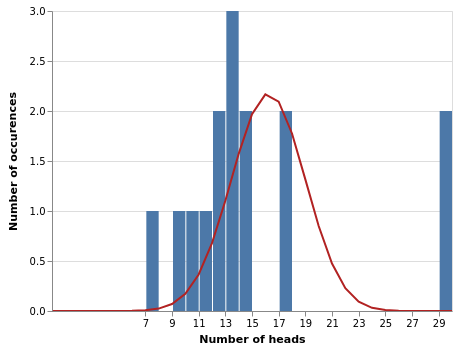

In [9]:
fig_1_a = (alt
           .Chart(head_counts)
           .mark_bar()
           .encode(alt.X("outcome:Q",
                         bin = alt.BinParams(step = 1),
                         title = "Number of heads"),
                   y = alt.Y("count()",
                            title = "Number of occurences")))

k_vals = range(0,31)
k_probs = [num_people * stats.binom.pmf(k = k, n = num_flips, p = 0.540) for k in k_vals]
binom_dist_df = pd.DataFrame({"value": k_vals,
                              "prob": k_probs})

fig_1_b = (alt
           .Chart(binom_dist_df)
           .mark_line(color= "firebrick")
           .encode(x = "value", 
                   y = "prob"))


fig_1_a + fig_1_b

### Exercise 4 part I

It looks like there might be a couple of strange points in this dataset as Mittens suspected. Using the upper bound on $p$ calculate the probability of someone getting all heads. Write a couple of sentences explaining whether you think it is reasonable to remove those data points.

In [10]:
stats.binom.pmf(k = 30, n = 30, p = 0.54)

9.371579521404065e-09

### Exercise 4 part II

Remove the outliers and repeat the process of plotting the data and estimating the parameters and CI. Once you have done this, plot the distribution of the estimated binomial distribution on top of the histogram. Write a couple of sentences explaining what you think about the coin now.

In [11]:
head_counts_clean = head_counts.loc[head_counts["outcome"] < 30]

total_heads_clean = int(head_counts_clean["outcome"].sum())
num_people_clean = int(head_counts_clean["name"].unique().size)

wald_estimate_and_ci(num_success=total_heads_clean, num_trials=num_people_clean * num_flips)

(0.4153846153846154, (0.3664761437453554, 0.4642930870238754))

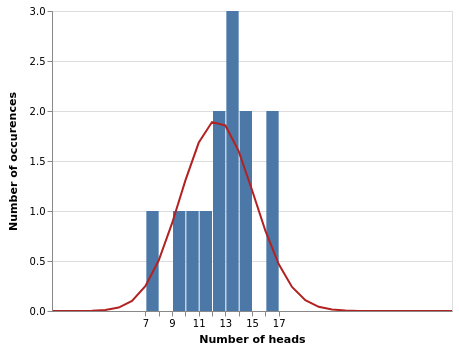

In [12]:
k_vals = range(0,31)
k_probs = [num_people_clean * stats.binom.pmf(k = k, n = num_flips, p = 0.415) for k in k_vals]
binom_dist_df = pd.DataFrame({"value": k_vals,
                              "prob": k_probs})

fig_2_a = (alt
           .Chart(head_counts_clean)
           .mark_bar()
           .encode(alt.X("outcome:Q",
                         bin = alt.BinParams(step = 1),
                         title = "Number of heads"),
                   y = alt.Y("count()",
                            title = "Number of occurences")))

fig_2_b = (alt
           .Chart(binom_dist_df)
           .mark_line(color= "firebrick")
           .encode(x = "value", y = "prob"))

fig_2_a + fig_2_b

## Experimental results: flipping coins in parallel

After the success of his first experiment, Mittens was lauded as a statistical wizard. The royal mint has become interested and is providing additional funds to obtain an additional 49 coins and repeat the experiment to gather more data about the fascinating topic of coin bias. Now he gives each of 50 students a coin each and asks them to flip the coin 30 times and record the results. We will help Mittens work out whether the coins are fair.

### Excercise 5 part I

Do we need to change anything about how we analyse this data? If so, why, if not, why not? **Hint:** there are good arguments that can be given for each answer. Once you have answered one way, try to answer the other way. 

### Partial answer

If you assume the coins have the same probability of heads it is fine. If you assume that the coins vary then you would need to adjust the model.

### Exercise 5 part II

Using the data in `experiment2.csv` explore the data set using the methodology devised above and write a couple of sentences to explain what you found.

In [13]:
exp2 = pd.read_csv("experiment2.csv")

head_counts = exp2.drop(columns="flip_number").groupby("name").sum()
head_counts["name"] = head_counts.index.copy()

total_heads = int(head_counts["outcome"].sum())
num_people = int(head_counts["name"].unique().size)
num_flips = int(exp2["name"].value_counts().unique())

wald_estimate = wald_estimate_and_ci(num_success=total_heads, 
                                     num_trials=num_people * num_flips)

print(wald_estimate)

(0.4013333333333333, (0.37652739859779666, 0.42613926806887))


### Exercise 5 part III

Visualise the number of heads each student got and compare the variance in this to what is predicted by theory. Revise your answer to part I of this exercise.

18.69224489795919 7.2079466666666665


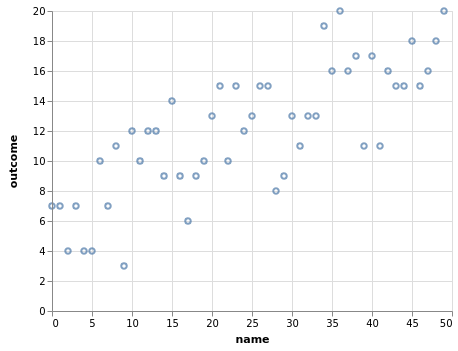

In [14]:
emp_var = head_counts["outcome"].var()
thry_var = stats.binom.var(n = num_flips, p = wald_estimate[0])

print(emp_var,thry_var)

alt.Chart(head_counts).mark_point().encode(
    x = "name",
    y = "outcome"
)

### Partial answer

- There appears to be systematic differences in the number of heads obtained.
- The variance is too great.
- It seems that we should not consider all the coins as identical.



### Exercise 5 part IV (Extension)

Consider how you might analyse this data. Over the following weeks you will learn a couple of approaches.

### Partial answer

One could use a negative binomial distribution if one were interested in an empirical analysis or a hierarchical model if one were interested in a structural analysis.

## Epilogue

Professor Mittens' work was published in a top tier journal and he was lauded as a statistical wizard. Rumour has it he will soon be elected to the British Acadmey.